In [13]:
#!/usr/bin/python
# coding:utf-8

'''
Created on 2017-04-07
Update  on 2017-11-17
Author: Peter/ApacheCN-xy/片刻
GitHub: https://github.com/apachecn/AiLearning
'''

from mrjob.job import MRJob
from mrjob.step import MRStep


class MRmean(MRJob):
    def __init__(self, *args, **kwargs):  # 对数据初始化
        super().__init__(*args, **kwargs)
        self.inCount = 0
        self.inSum = 0
        self.inSqSum = 0

    # 接受输入数据流
    def map(self, key, val):  # 以key/value的形式传递
        if False:
            yield
        inVal = float(val)
        self.inCount += 1
        self.inSum += inVal
        self.inSqSum += inVal*inVal

    # 所有输入到达后开始处理
    def map_final(self):  # 计算数据的平均值，平方的均值，并返回
        if self.inCount == 0:
            return
        mean = self.inSum/self.inCount
        meanSq = self.inSqSum/self.inCount
        # 所有的mapper都以 1做为key(即所有的mapper最后在同一个reducer里处理)
        yield (1, [self.inCount, mean, meanSq])

    def reduce(self, key, packedValues):
        cumN, cumVal, cumSumSq = 0.0, 0.0, 0.0
        for valArr in packedValues:  # 从输入流中获取值
            nj = float(valArr[0])
            cumN += nj
            cumVal += nj*float(valArr[1])
            cumSumSq += nj*float(valArr[2])
        mean = cumVal/cumN
        var = (cumSumSq - 2*mean*cumVal + cumN*mean*mean)/cumN
        yield (mean, var)  # 发出平均值和方差
        # 如果reduce后还要执行另一个mapper, 那么仍然需要一个key

    def steps(self):
        """
        step方法定义执行的步骤。
        执行顺序不必完全遵循map-reduce模式。
        例如：
            1. map-reduce-reduce-reduce
            2. map-reduce-map-reduce-map-reduce
        在step方法里，需要为mrjob指定mapper和reducer的名称。如果没有，它将默认调用mapper和reducer方法。

        在mapper 和 mapper_final中还可以共享状态，mapper 或 mapper_final 不能与 reducer之间共享状态。
        """
        return [MRStep(mapper=self.map, mapper_final=self.map_final, reducer=self.reduce)]

In [17]:
import matplotlib.pyplot as plt
import numpy as np
 
data = np.loadtxt('./data/testSet.txt')

In [71]:
X , y = data[:, :-1], data[:, -1].astype(int)
y.shape

(200,)

In [64]:
def predict(w, X):
    return w @ X.T

def batchPegasos(dataSet, labels, lam, T, k):
    """batchPegasos()

    Args:
        dataMat    特征集合
        labels     分类结果集合
        lam        固定值
        T          迭代次数
        k          待处理列表大小
    Returns:
        w          回归系数
    """
    m, n = np.shape(dataSet)
    w = np.zeros(n)  # 回归系数
    dataIndex = list(range(m))
    for t in range(1, T+1):
        wDelta = np.mat(np.zeros(n))  # 重置 wDelta

        # 它是学习率，代表了权重调整幅度的大小。（也可以理解为随机梯度的步长，使它不断减小，便于拟合）
        # 输入T和K分别设定了迭代次数和待处理列表的大小。在T次迭代过程中，每次需要重新计算eta
        eta = 1.0/(lam*t)
        np.random.shuffle(dataIndex)  # 随机挑选样本
        for j in range(k):      # 全部的训练集  内循环中执行批处理，将分类错误的值全部做累加后更新权重向量
            i = dataIndex[j]
            p = predict(w, dataSet[i, :])              # mapper 代码

            # 如果预测正确，并且预测结果的绝对值>=1，因为最大间隔为1, 认为没问题。
            # 否则算是预测错误, 通过预测错误的结果，来累计更新w.
            if labels[i]*p < 1:                        # mapper 代码
                wDelta += labels[i]*dataSet[i, :].A      # 累积变化
        # w通过不断的随机梯度的方式来优化
        w = (1.0 - 1/t)*w + (eta/k)*wDelta             # 在每个 T上应用更改
        # print '-----', w
    # print '++++++', w
    return w

In [82]:
w50 = batchPegasos(np.mat(X), y, lam=2, T=50, k=100)
w2 = batchPegasos(np.mat(X), y, lam=2, T=2, k=100)
print(w50)
print(w2)

[[ 0.43801735 -0.11763337]]
[[ 0.55057071 -0.02227303]]


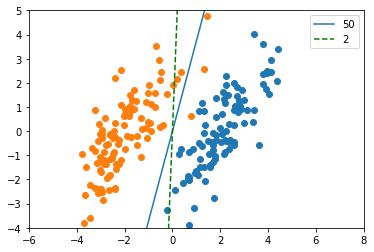

In [83]:
x = np.arange(-6.0, 8.0, 0.1)
y1 = (-w50[0, 0]*x - 0)/w50[0, 1]
y2 = (-w2[0, 0]*x - 0)/w2[0, 1]
plt.plot(x, y1, label='50')
plt.plot(x, y2, 'g--', label='2')
right_ = y == 1
plt.scatter(X[right_, 0], X[right_, 1])
plt.scatter(X[~right_, 0], X[~right_, 1])
plt.axis([-6, 8, -4, 5])
plt.legend()